### In this notebook we will calibrate forward model from monochromator measurements, and make a dataset. 

To calibrate, I need the dispersion from the center, the standard deviation of gaussian of each peak

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import os, sys
main_dir = os.path.abspath('../../')
sys.path.insert(0, main_dir)

import models.helper as hlp
from models.custom.model import *
import forward.fourier.method as fwd
from forward.fourier.kernel_creator import create_fourier_kernel
from skimage.feature import peak_local_max
from scipy.ndimage import center_of_mass, shift

from torchvision.transforms import GaussianBlur


import gc
def clear_gpu():
    gc.collect()
    torch.cuda.empty_cache()

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


%load_ext autoreload
%autoreload 2

/home/s/Sunny.Howard/anaconda3/envs/torchenv/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/home/s/Sunny.Howard/anaconda3/envs/torchenv/lib/python3.10/site-packages/torchvision/image.so: undefined symbol: _ZN5torch3jit17parseSchemaOrNameERKNSt7__cxx1112basic_stringIcSt11char_traitsIcESaIcEEE'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [2]:
dir = '/project/agdoepp/Experiment/Hyperspectral_Calibration_FTS/microlens_26012024/'

files = os.listdir(dir)
files = [f for f in files if f.endswith('.npy')]

calibration_dir = '/project/agdoepp/Experiment/Hyperspectral_Calibration_FTS/microlens_18012024_new/'

In [3]:

bitdepth = 16
# orientation = 'straight'

measurements = torch.stack([torch.tensor((np.load(dir + file) / 2**bitdepth).astype(np.float32)) for file in files])# if str(bitdepth) in file and orientation in file and 'tiff' in file])

measurements = torch.nan_to_num(measurements, nan = torch.nan_to_num(measurements).max())



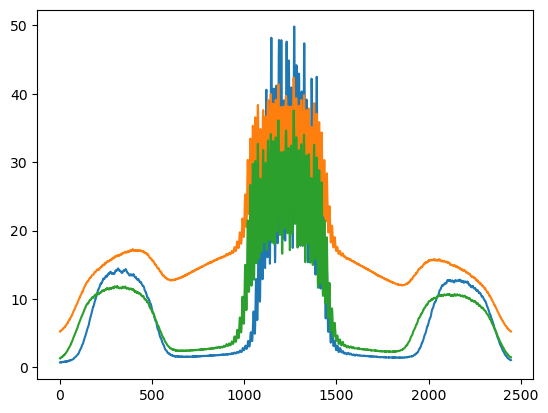

In [4]:
plt.plot(measurements[0].sum(0).cpu().numpy())

plt.plot(measurements[1].sum(0).cpu().numpy())
plt.plot(measurements[2].sum(0).cpu().numpy())

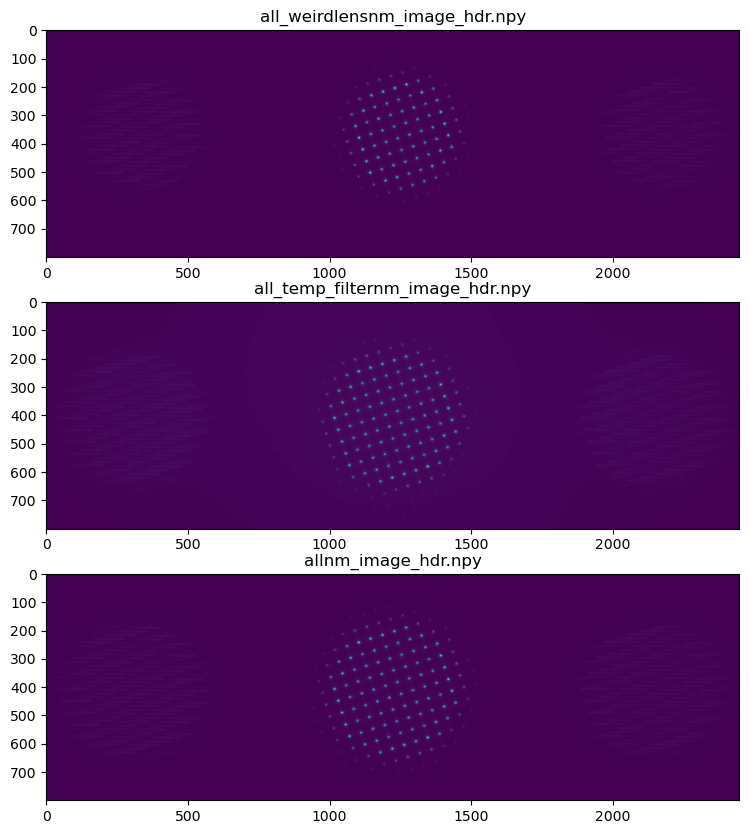

In [5]:
fig,ax = plt.subplots(3,1, figsize = (10,10))
for i in range(3):
    ax[i].imshow(measurements[i])
    ax[i].set_title(files[i])


In [6]:
m_no = -1

cali_measurement = measurements[-1].clone()



box_size = 59 #from the calibration

abs_dispersion_plus1 = torch.load(calibration_dir + 'abs_dispersion_plus1.pt')
abs_dispersion_minus1 = torch.load(calibration_dir + 'abs_dispersion_minus1.pt')

n_wl = abs_dispersion_minus1.shape[1]
mid_wl =  n_wl// 2

### Now the process of extracting the boxes:


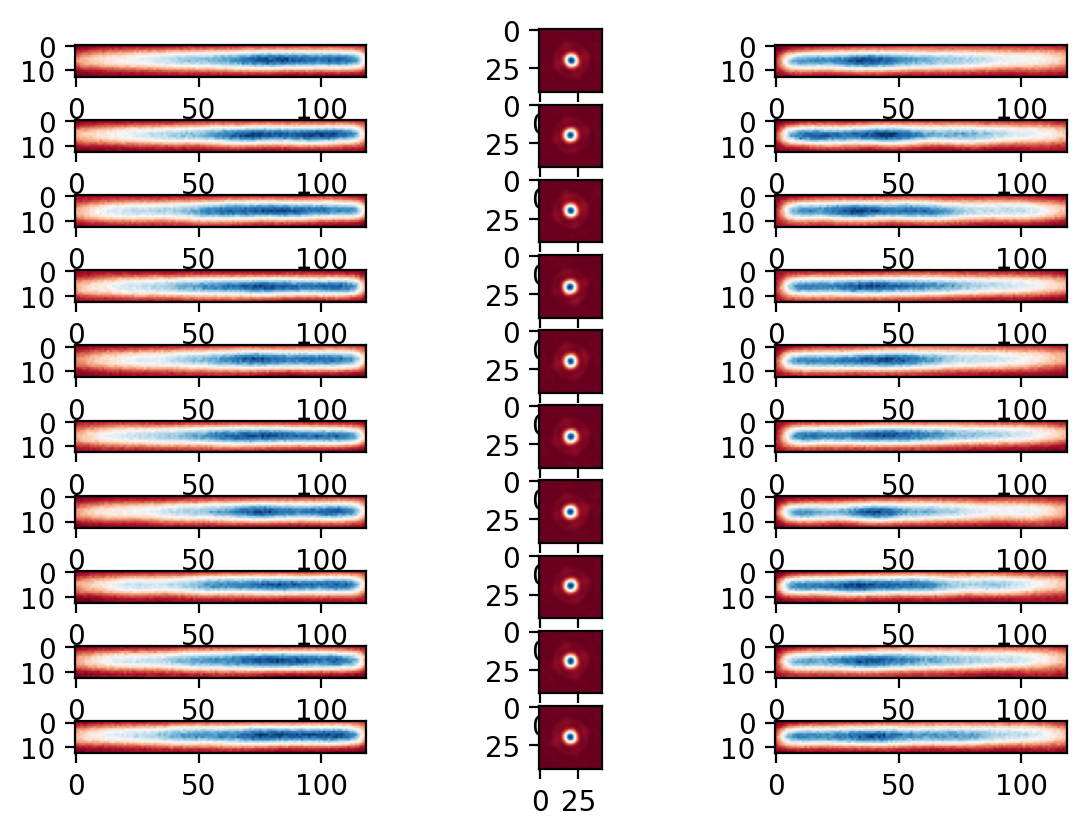

In [7]:
num_peaks = 60

def extract_peaks(measurement, center_wl_peak_positions_f = None, center_wl_peak_positions_m1 = None, center_wl_peak_positions_p1 = None):
    ''' 
    measurement is 2d
    '''

    if center_wl_peak_positions_f is None:
        neighbour_peaks = peak_local_max(measurement[:,900:1500].numpy(), min_distance=30, threshold_rel = 0.01) + np.array([0,900])[None,:]

        neighbour_peaks = neighbour_peaks[:60]
        center_wl_peak_positions_m1_exact = neighbour_peaks + abs_dispersion_minus1[:,mid_wl][None]
        center_wl_peak_positions_m1 = np.round(center_wl_peak_positions_m1_exact).astype(int)
        # m1_rounding_correction = center_wl_peak_positions_m1_exact - center_wl_peak_positions_m1

        center_wl_peak_positions_p1_exact = neighbour_peaks + abs_dispersion_plus1[:,mid_wl][None]
        center_wl_peak_positions_p1 = np.round(center_wl_peak_positions_p1_exact).astype(int)
        # p1_rounding_correction = center_wl_peak_positions_p1_exact - center_wl_peak_positions_p1



        center_wl_peak_positions_f = np.round(neighbour_peaks).astype(int)
        # f_rounding_correction = neighbour_peaks - center_wl_peak_positions_f




    all_m1s = []
    all_p1s = []
    all_fs = []

    border = 6
    fborder = 20

    for peakno in range(num_peaks):

        m1 = measurement[center_wl_peak_positions_m1[peakno,0]-border:center_wl_peak_positions_m1[peakno,0]+border+1,center_wl_peak_positions_m1[peakno,1]-box_size:center_wl_peak_positions_m1[peakno,1]+box_size+1]
        p1 = measurement[center_wl_peak_positions_p1[peakno,0]-border:center_wl_peak_positions_p1[peakno,0]+border+1,center_wl_peak_positions_p1[peakno,1]-box_size:center_wl_peak_positions_p1[peakno,1]+box_size+1]
        f = measurement[center_wl_peak_positions_f[peakno,0]-fborder:center_wl_peak_positions_f[peakno,0]+fborder+1,center_wl_peak_positions_f[peakno,1]-fborder:center_wl_peak_positions_f[peakno,1]+fborder+1]

        norm = f.sum()

        m1 = m1/norm
        p1 = p1/norm
        f = f/norm

        all_m1s.append(m1)
        all_p1s.append(p1)
        all_fs.append(f)
        
    all_m1s = torch.stack(all_m1s)
    all_p1s = torch.stack(all_p1s)
    all_fs = torch.stack(all_fs)

    return all_m1s, all_p1s, all_fs, center_wl_peak_positions_m1, center_wl_peak_positions_p1, center_wl_peak_positions_f


cali_all_m1s, cali_all_p1s, cali_all_fs, cali_center_wl_peak_positions_m1, cali_center_wl_peak_positions_p1, cali_center_wl_peak_positions_f = extract_peaks(cali_measurement)


fig,ax = plt.subplots(10,3,dpi=200)

# for i,peakno in enumerate(np.linspace(0,len(center_wl_peak_positions_m1)-1,10).astype(int)):
for i,peakno in enumerate(np.arange(10)):
    ax[i,0].imshow(cali_all_m1s[peakno],cmap='RdBu')
    ax[i,1].imshow(cali_all_fs[peakno],cmap='RdBu')
    ax[i,2].imshow(cali_all_p1s[peakno],cmap='RdBu')


In [8]:
class FCN(nn.Module):
    def __init__(self, input_size, output_size, dropout_factor = 0.5):
        super(FCN, self).__init__()

        scale = 2

        input_dropout = 0
        self.dropout0 = nn.Dropout(input_dropout)
        self.batchnorm0 = nn.BatchNorm1d(input_size)

        self.dense1 = nn.Linear(input_size, scale * 1000* int(1/(1-input_dropout)))
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(dropout_factor)
        self.batchnorm1 = nn.BatchNorm1d(scale * 1000* int(1/(1-input_dropout)))


        self.dense2 = nn.Linear(scale * 1000* int(1/(1-input_dropout)), scale * 500 * int(1/(1-dropout_factor)))
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(dropout_factor)
        self.batchnorm2 = nn.BatchNorm1d(scale * 500 * int(1/(1-dropout_factor)))


        # self.dense3 = nn.Linear(scale * 500* int(1/(1-dropout_factor)),scale *  100 * int(1/(1-dropout_factor)))
        # self.relu3 = nn.ReLU()
        # self.dropout3 = nn.Dropout(dropout_factor)
        # self.batchnorm3 = nn.BatchNorm1d(scale * 100 * int(1/(1-dropout_factor)))

        # self.dense4 = nn.Linear(scale * 100* int(1/(1-dropout_factor)),scale *  100 * int(1/(1-dropout_factor)))
        # self.relu4 = nn.ReLU()
        # self.dropout4 = nn.Dropout(dropout_factor)
        # self.batchnorm4 = nn.BatchNorm1d(scale * 100 * int(1/(1-dropout_factor)))



        self.dense4_pred = nn.Linear(scale * 500* int(1/(1-dropout_factor)), output_size[0] * output_size[1])
        self.dense4_var = nn.Linear(scale * 500* int(1/(1-dropout_factor)), output_size[0] * output_size[1])

        self.relu4 = nn.ReLU()
        self.exp = nn.Softplus()


        self.output_size = output_size

    def forward(self, x):
        # x = self.dropout0(x)
        # x = self.batchnorm0(x)
        x = self.dense1(x)
        x = self.relu1(x)
        x = self.dropout1(x)
        x = self.batchnorm1(x)
        x = self.dense2(x)
        x = self.relu2(x)
        x = self.dropout2(x)
        x = self.batchnorm2(x)

        # x = self.dense3(x)
        # x = self.relu3(x)#
        # x = self.dropout3(x)
        # x = self.batchnorm3(x)

        # x = self.dense4(x)
        # x = self.relu4(x)#
        # x = self.dropout4(x)
        # x = self.batchnorm4(x)

        pred = self.dense4_pred(x)

        var = self.dense4_var(x)
        # var = self.exp(var)
        var = torch.exp(var)

        pred, var = pred.reshape(-1,self.output_size[0],self.output_size[1]), var.reshape(-1,self.output_size[0],self.output_size[1])

        pred[:,0] = torch.sigmoid(pred[:,0])

        return pred,var
    
def collate_data(m1, p1, f, device = device):
    
    # x_data = torch.concat((m1.reshape(len(m1),-1), p1.reshape(len(m1),-1), f.reshape(len(m1),-1), f_peak_locs), dim = 1).float().to(device)
    x_data = torch.concat((m1.reshape(len(m1),-1), p1.reshape(len(m1),-1), f.reshape(len(m1),-1)), dim = 1).float().to(device)

    return x_data

In [9]:
cali_x_data_test = collate_data(cali_all_m1s, cali_all_p1s, cali_all_fs)
correlation_matrix = torch.load(calibration_dir + 'correlation_matrix.pt')

variance_model = FCN(cali_x_data_test.shape[1], [3,33], dropout_factor=0).to(device)

variance_model.load_state_dict(torch.load('variance_model.pt'))

<All keys matched successfully>

0.19663937 0.07032647


Text(0.5, 1.0, 'phase y')

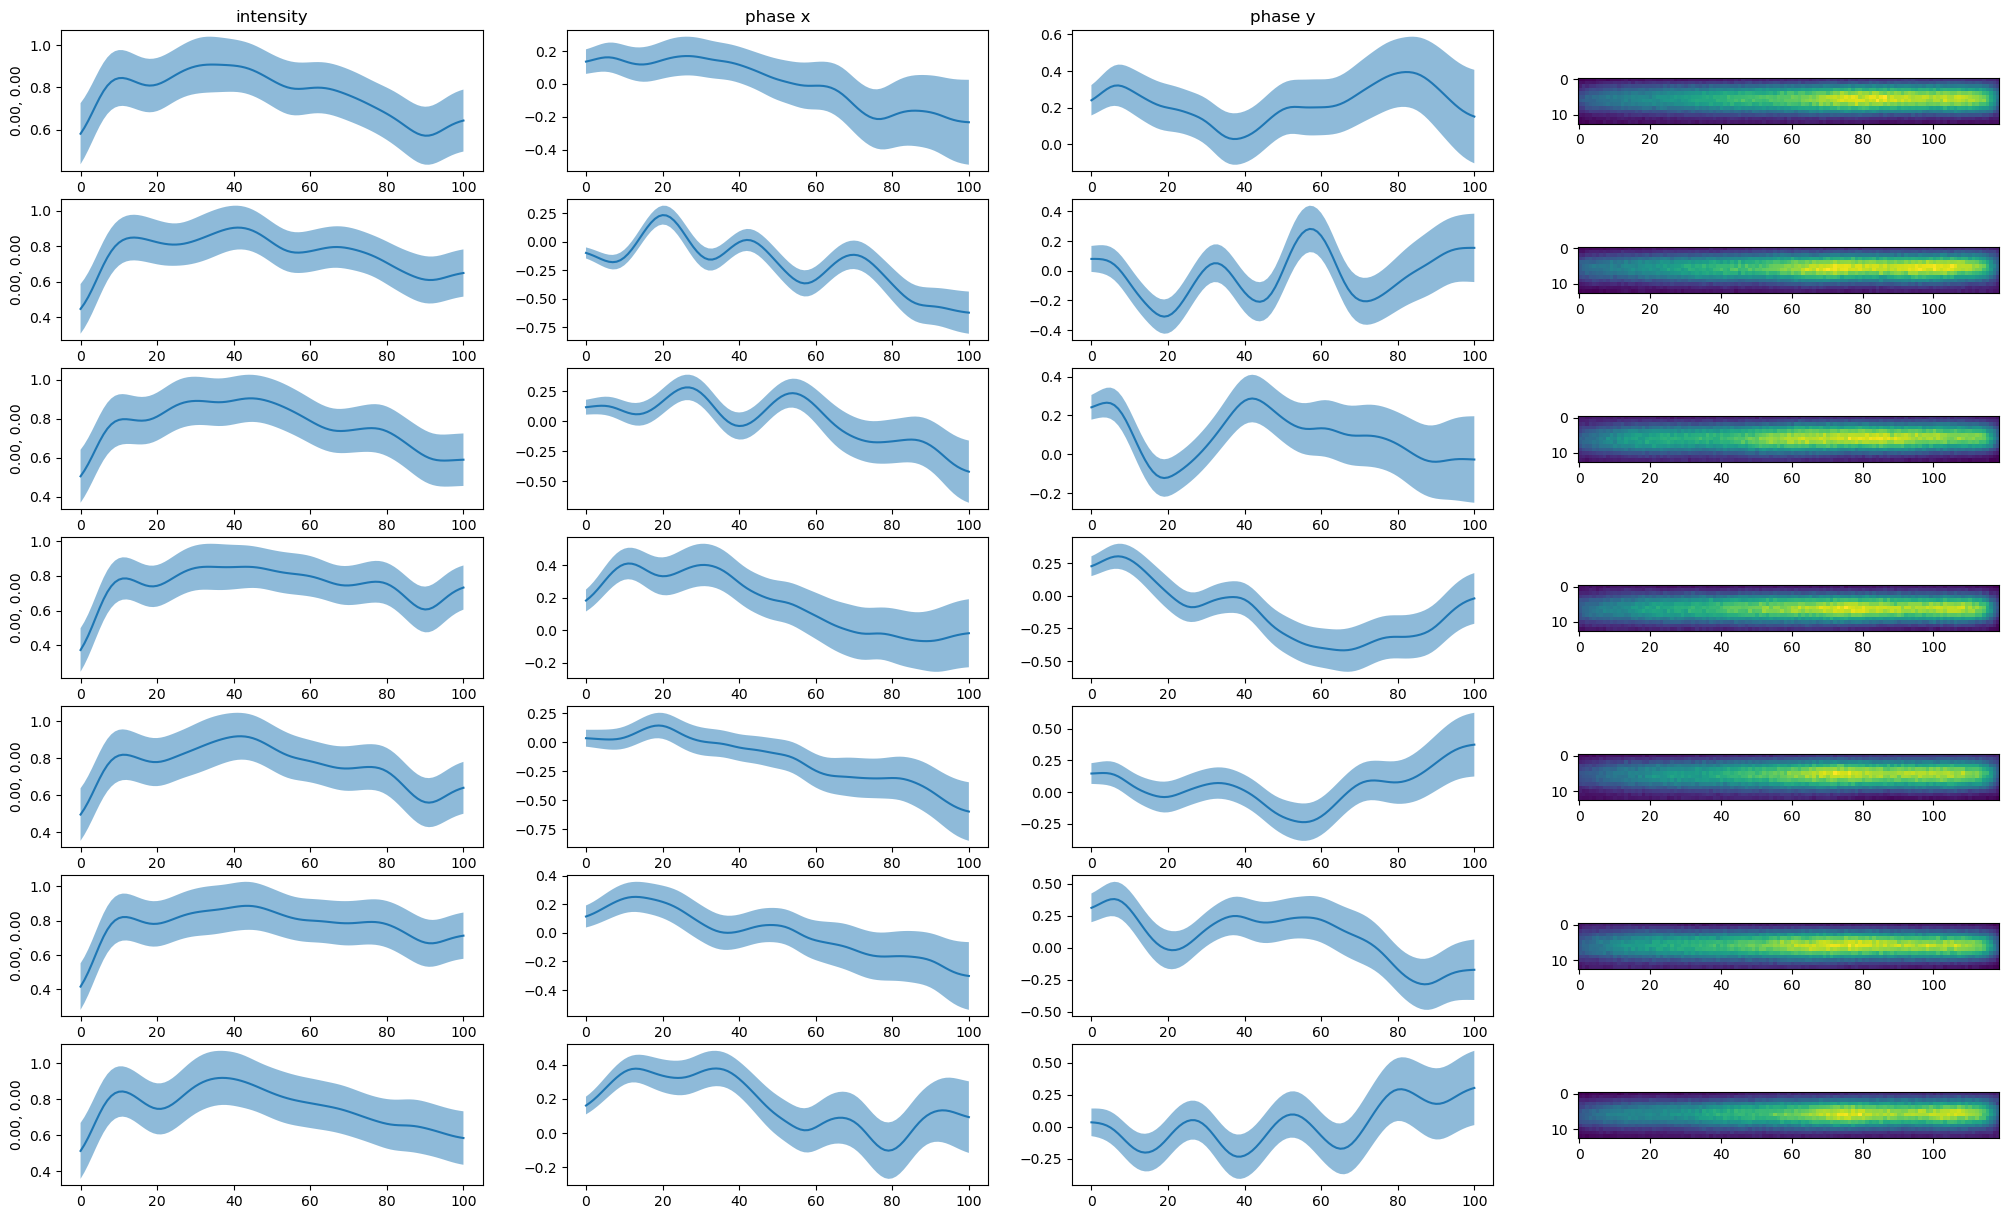

In [10]:
variance_model.eval()


expected, variance = variance_model(cali_x_data_test)

expected = expected.cpu().detach().numpy()
variance = variance.cpu().detach().numpy() 

expected = np.einsum('ijk,lk->ijl',expected,correlation_matrix)
variance = np.einsum('ijk,lk->ijl',variance,correlation_matrix)

std = np.sqrt(variance)

print(std.max(), std.mean())

no_sigma = 2

fig,ax = plt.subplots(7 ,4, figsize = (25,15))

for i in range(7):
    ax[i,0].set_ylabel(f'{cali_x_data_test[i,-2]:.2f}, {cali_x_data_test[i,-1]:.2f}')

    ax[i,0].plot(expected[i,0],label='predicted')
    ax[i,0].fill_between(np.arange(len(expected[0,0])), expected[i,0]-std[i,0]  * no_sigma, expected[i,0]+std[i,0] * no_sigma, alpha = 0.5)
    # ax[i,0].set_ylim(-.05,1.05)

    ax[i,1].plot(expected[i,1],label='predicted')
    ax[i,1].fill_between(np.arange(len(expected[0,1])), expected[i,1]-std[i,1] * no_sigma , expected[i,1]+std[i,1] * no_sigma, alpha = 0.5)
    # ax[i,1].set_ylim(-2.05,2.05)


    ax[i,2].plot(expected[i,2],label='predicted')
    ax[i,2].fill_between(np.arange(len(expected[0,2])), expected[i,2]-std[i,2]  * no_sigma, expected[i,2]+std[i,2] * no_sigma, alpha = 0.5)
    # ax[i,2].set_ylim(-2.05,2.05)

    ax[i,3].imshow(cali_all_m1s[i],label='predicted')


ax[0,0].set_title('intensity'); ax[0,1].set_title('phase x'); ax[0,2].set_title('phase y')


In [11]:
cali_intensities = expected[:,0]

cali_peak_locations = np.zeros((len(cali_all_m1s),2,n_wl))

cali_peak_locations[:,0] = cali_center_wl_peak_positions_f[:,0][:,None] + expected[:,1]
cali_peak_locations[:,1] = cali_center_wl_peak_positions_f[:,1][:,None] + expected[:,2]

cali_std = std

## Lets compare to the thermal lense data

In [12]:
therm_measurement = measurements[1]

therm_all_m1s, therm_all_p1s, therm_all_fs, therm_center_wl_peak_positions_m1, therm_center_wl_peak_positions_p1, therm_center_wl_peak_positions_f  = extract_peaks(therm_measurement)

therm_x_data_test = collate_data(therm_all_m1s, therm_all_p1s, therm_all_fs)


0.41537097 0.18895563


Text(0.5, 1.0, 'phase y')

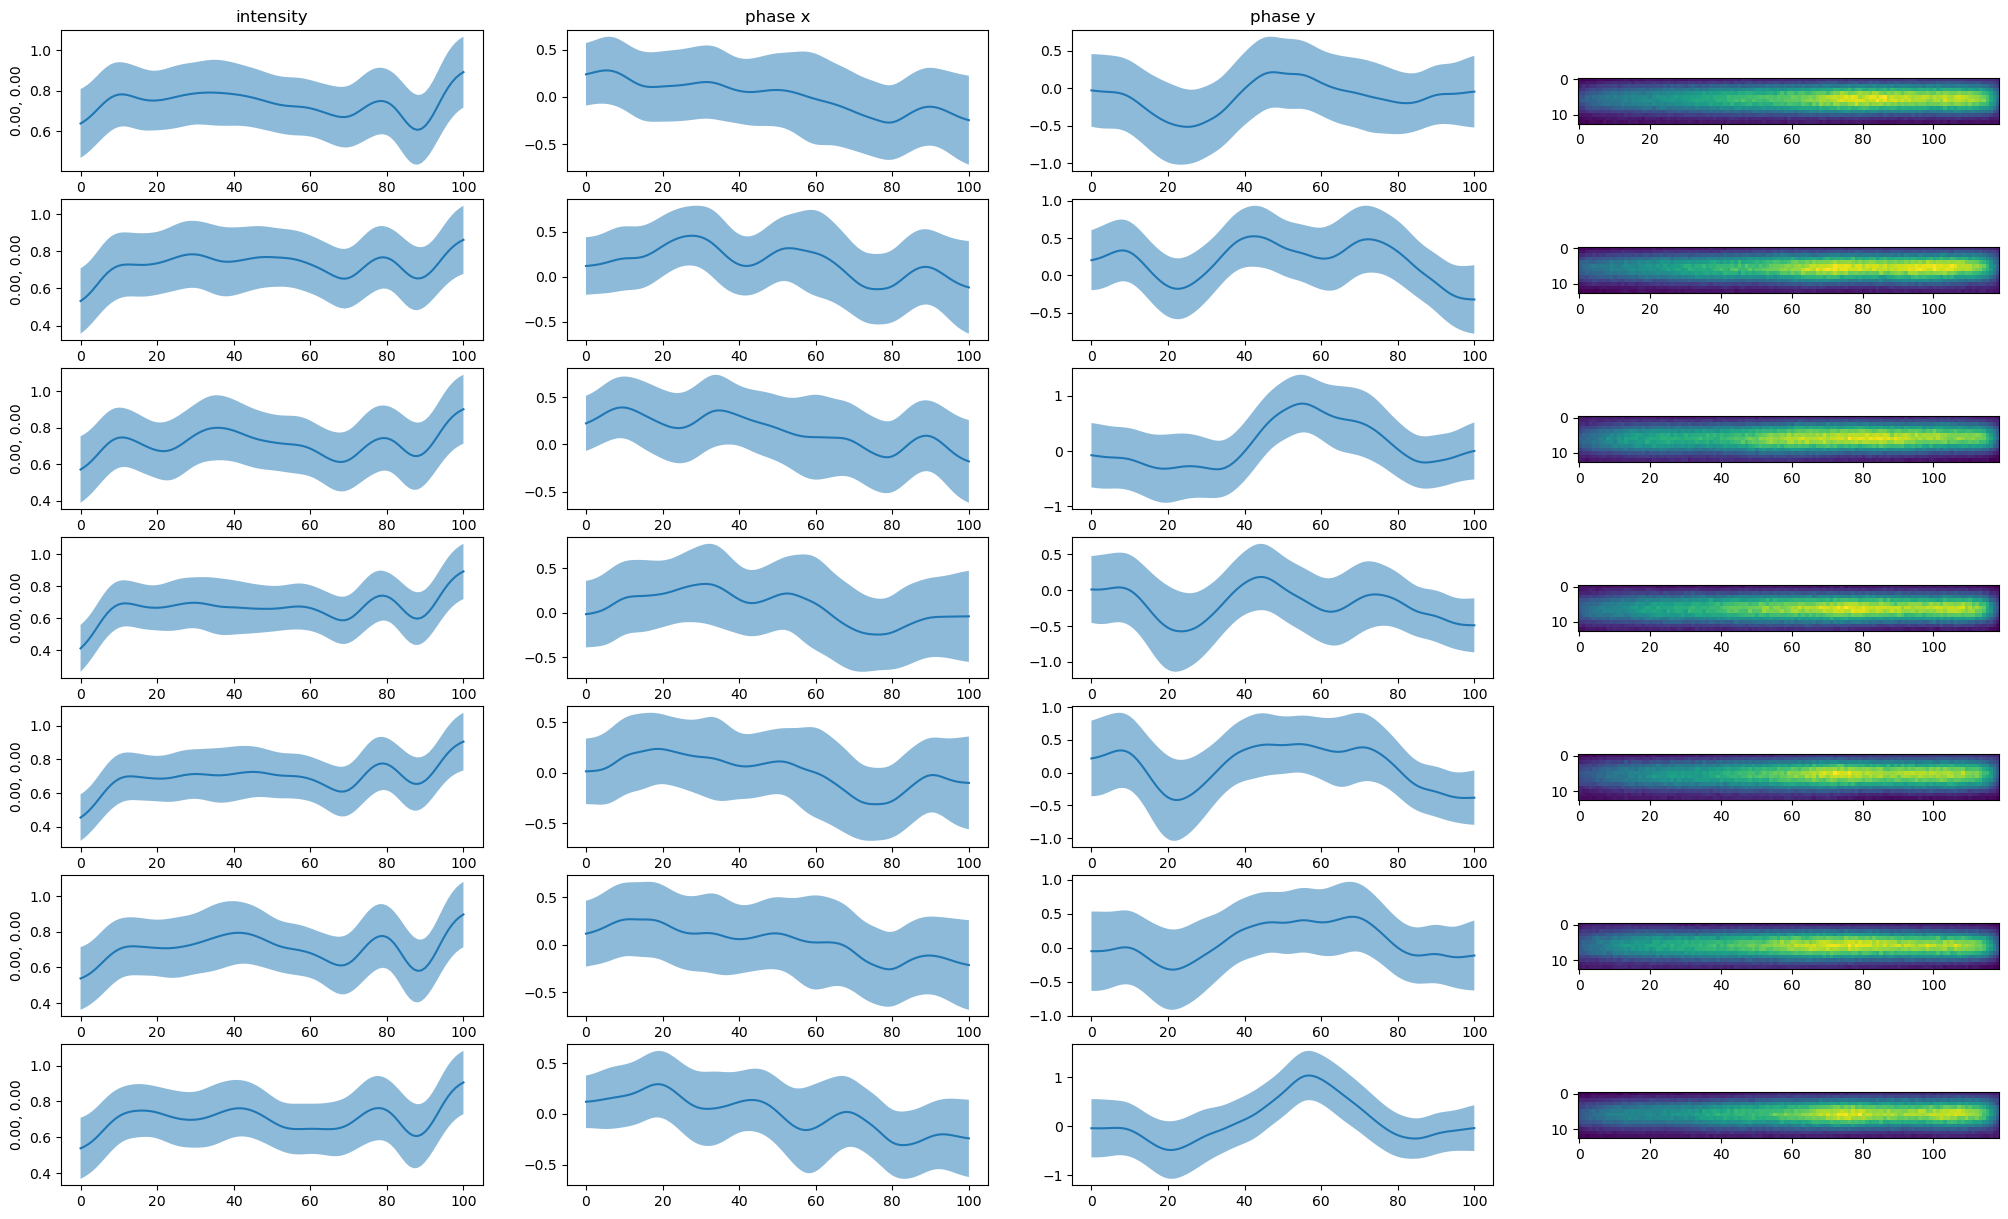

In [13]:
expected, variance = variance_model(therm_x_data_test)

expected = expected.cpu().detach().numpy()
variance = variance.cpu().detach().numpy() 

expected = np.einsum('ijk,lk->ijl',expected,correlation_matrix)
variance = np.einsum('ijk,lk->ijl',variance,correlation_matrix)

std = np.sqrt(variance)

print(std.max(), std.mean())

no_sigma = 2

fig,ax = plt.subplots(7 ,4, figsize = (25,15))

for i in range(7):
    ax[i,0].set_ylabel(f'{cali_x_data_test[i,-2]:.2f}, {cali_x_data_test[i,-1]:.2f}')

    ax[i,0].plot(expected[i,0],label='predicted')
    ax[i,0].fill_between(np.arange(len(expected[0,0])), expected[i,0]-std[i,0]  * no_sigma, expected[i,0]+std[i,0] * no_sigma, alpha = 0.5)
    # ax[i,0].set_ylim(-.05,1.05)

    ax[i,1].plot(expected[i,1],label='predicted')
    ax[i,1].fill_between(np.arange(len(expected[0,1])), expected[i,1]-std[i,1] * no_sigma , expected[i,1]+std[i,1] * no_sigma, alpha = 0.5)
    # ax[i,1].set_ylim(-2.05,2.05)


    ax[i,2].plot(expected[i,2],label='predicted')
    ax[i,2].fill_between(np.arange(len(expected[0,2])), expected[i,2]-std[i,2]  * no_sigma, expected[i,2]+std[i,2] * no_sigma, alpha = 0.5)
    # ax[i,2].set_ylim(-2.05,2.05)

    ax[i,3].imshow(cali_all_m1s[i],label='predicted')


ax[0,0].set_title('intensity'); ax[0,1].set_title('phase x'); ax[0,2].set_title('phase y')


In [14]:
therm_intensities = expected[:,0]

therm_peak_locations = np.zeros((len(cali_all_m1s),2,n_wl))

therm_peak_locations[:,0] = therm_center_wl_peak_positions_f[:,0][:,None] + expected[:,1]
therm_peak_locations[:,1] = therm_center_wl_peak_positions_f[:,1][:,None] + expected[:,2]

therm_std = std

In [15]:
#import distance from scipy
from scipy.spatial.distance import cdist

#calculate the distance between the calibration and the thermography peaks
dist = cdist(cali_center_wl_peak_positions_f, therm_center_wl_peak_positions_f)

dist[dist<5] = 0

comparible_peaks = np.where(dist==0)

In [16]:
cali_std.shape

(60, 3, 101)

Text(0.5, 1.0, 'pos y')

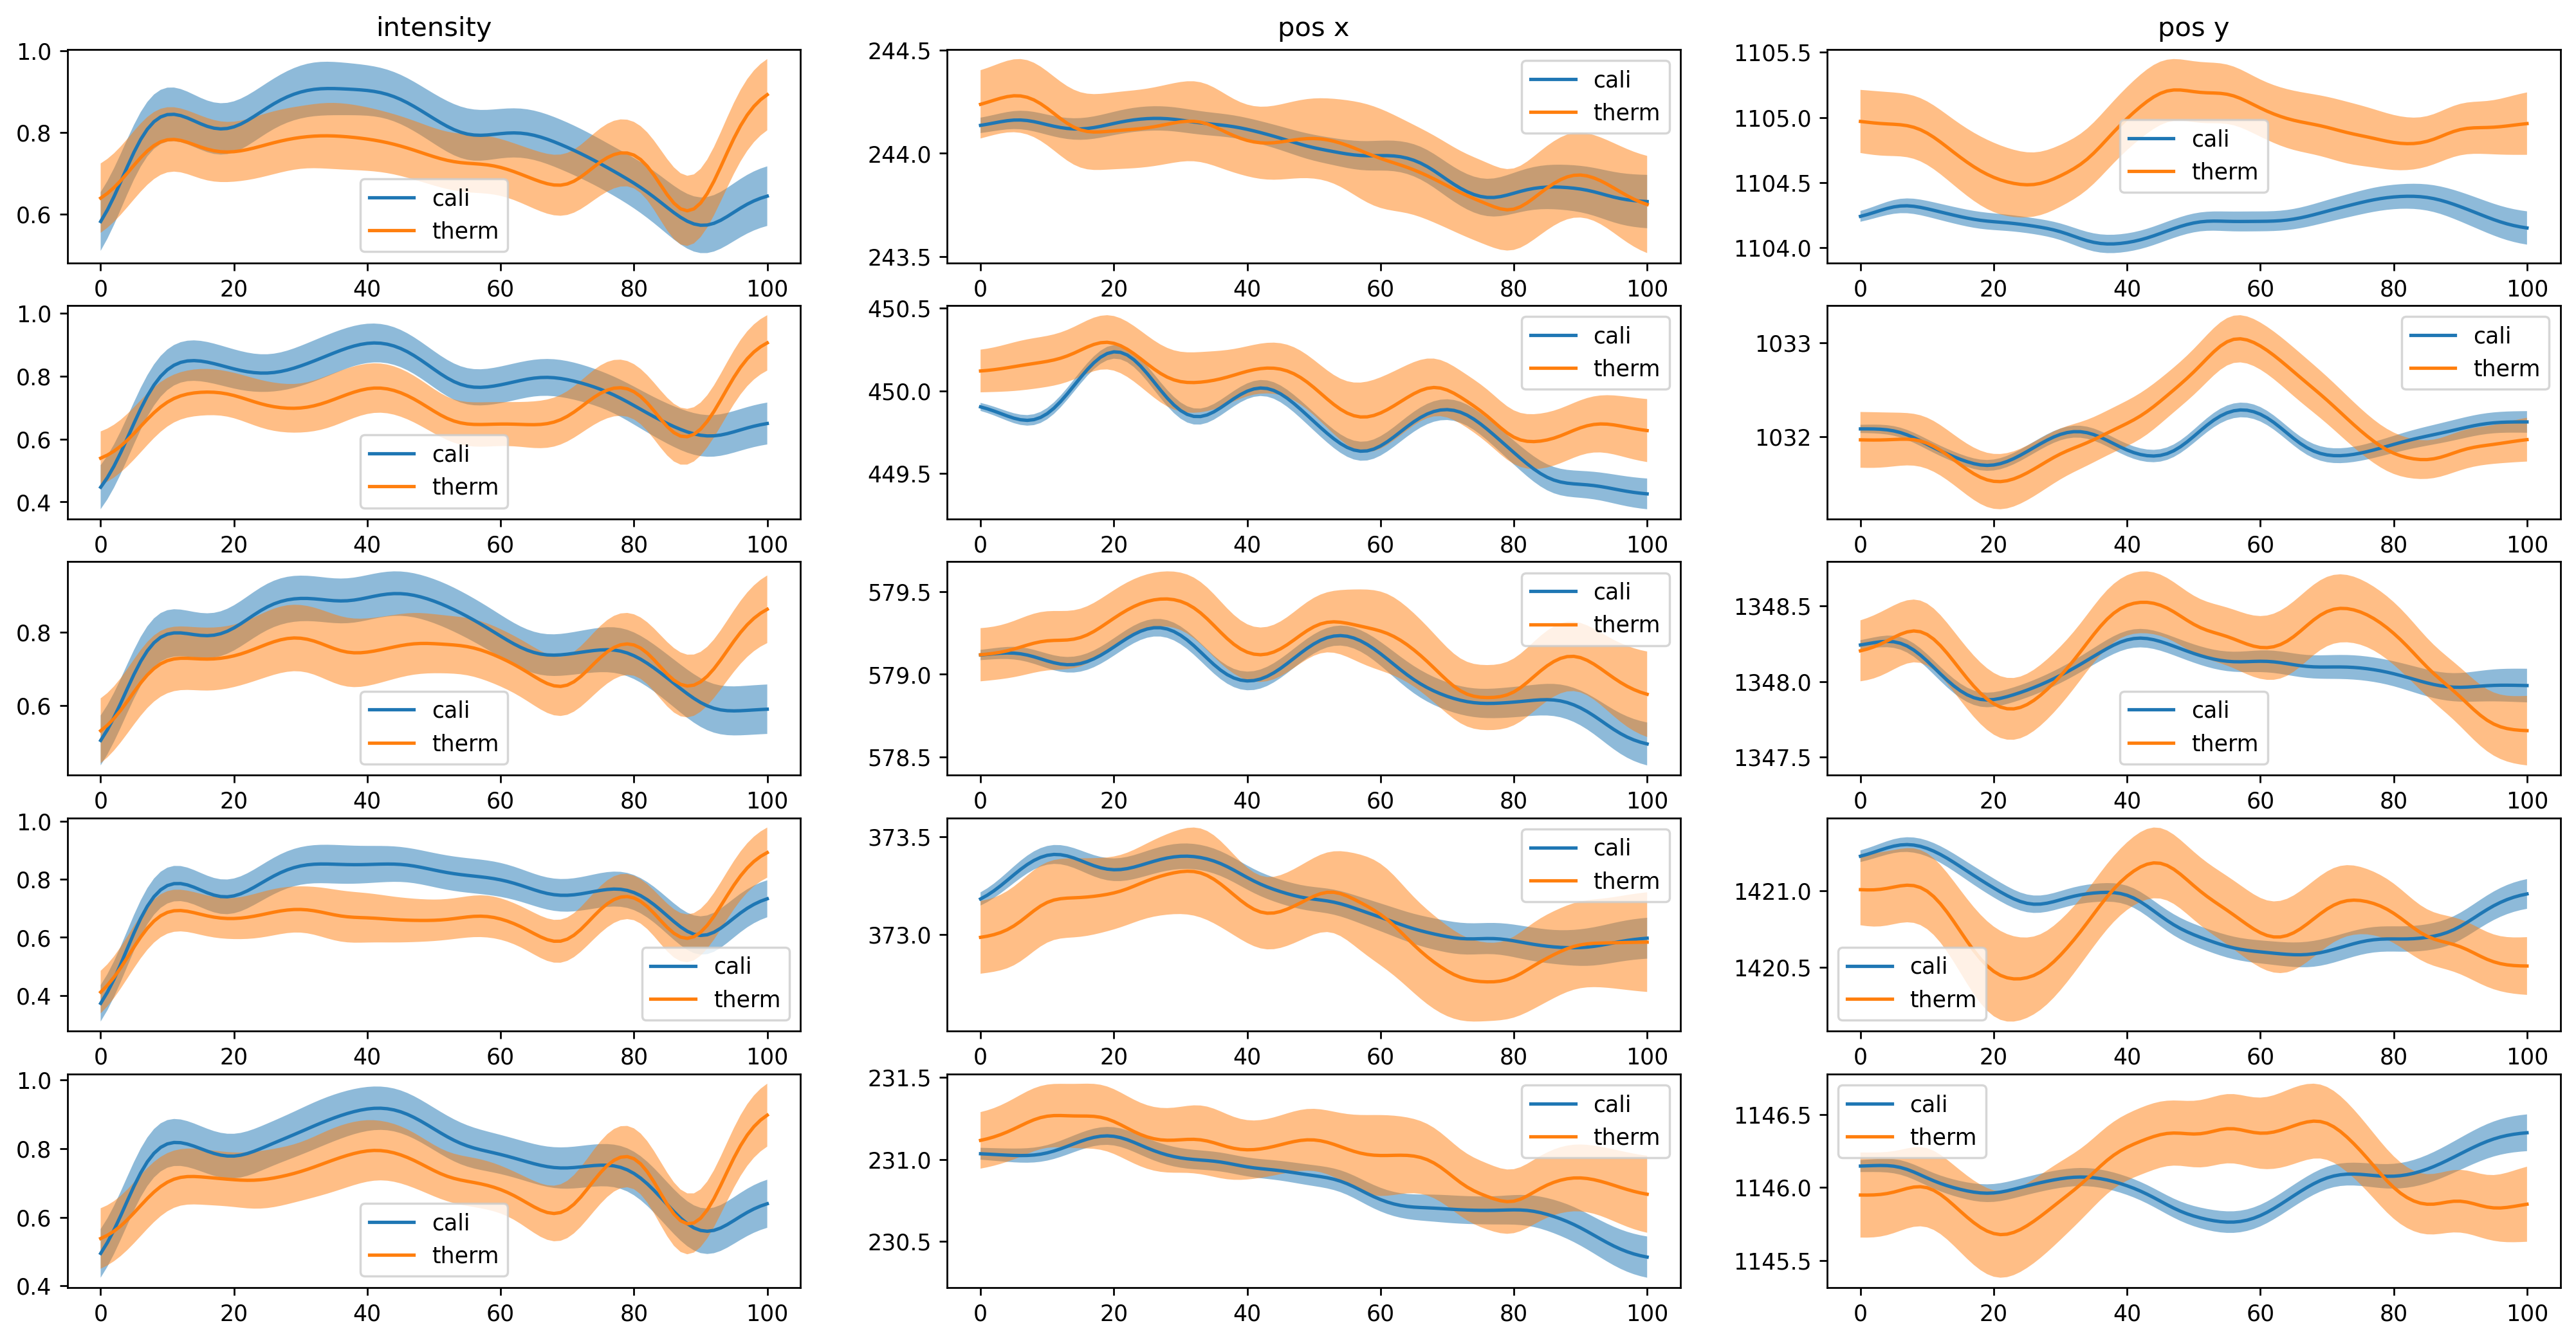

In [17]:
fig,ax = plt.subplots(5,3,figsize=(20,10),dpi=250)

no_sigma = 1

for i in range(5):
    cali_idx = comparible_peaks[0][i]
    therm_idx = comparible_peaks[1][i]
    ax[i,0].plot(cali_intensities[cali_idx], label = 'cali')
    ax[i,0].fill_between(np.arange(len(cali_intensities[cali_idx])), cali_intensities[cali_idx]-cali_std[cali_idx,0]  * no_sigma, cali_intensities[cali_idx]+cali_std[cali_idx,0] * no_sigma, alpha = 0.5)
    ax[i,0].plot(therm_intensities[therm_idx], label = 'therm')
    ax[i,0].fill_between(np.arange(len(therm_intensities[therm_idx])), therm_intensities[therm_idx]-therm_std[therm_idx,0]  * no_sigma, therm_intensities[therm_idx]+therm_std[therm_idx,0] * no_sigma, alpha = 0.5)
    ax[i,0].legend()

    ax[i,1].plot(cali_peak_locations[cali_idx,0], label = 'cali')
    ax[i,1].fill_between(np.arange(len(cali_intensities[cali_idx])), cali_peak_locations[cali_idx,0]-cali_std[cali_idx,1]  * no_sigma, cali_peak_locations[cali_idx,0]+cali_std[cali_idx,1] * no_sigma, alpha = 0.5)
    ax[i,1].plot(therm_peak_locations[therm_idx,0], label = 'therm')
    ax[i,1].fill_between(np.arange(len(therm_intensities[therm_idx])), therm_peak_locations[therm_idx,0]-therm_std[therm_idx,1]  * no_sigma, therm_peak_locations[therm_idx,0]+therm_std[therm_idx,1] * no_sigma, alpha = 0.5)
    ax[i,1].legend()

    ax[i,2].plot(cali_peak_locations[cali_idx,1], label = 'cali')
    ax[i,2].fill_between(np.arange(len(cali_intensities[cali_idx])), cali_peak_locations[cali_idx,1]-cali_std[cali_idx,2]  * no_sigma, cali_peak_locations[cali_idx,1]+cali_std[cali_idx,2] * no_sigma, alpha = 0.5)
    ax[i,2].plot(therm_peak_locations[therm_idx,1], label = 'therm')
    ax[i,2].fill_between(np.arange(len(therm_intensities[therm_idx])), therm_peak_locations[therm_idx,1]-therm_std[therm_idx,2]  * no_sigma, therm_peak_locations[therm_idx,1]+therm_std[therm_idx,2] * no_sigma, alpha = 0.5)
    ax[i,2].legend()

ax[0,0].set_title('intensity'); ax[0,1].set_title('pos x'); ax[0,2].set_title('pos y')

## Now we can try compare to the lens data. However i need to register the peaks to eachother... 

In [18]:
lens_measurement = measurements[0].clone()

In [19]:
#import com

threshed_lens = lens_measurement[:,900:1500].numpy().copy()
threshed_lens[threshed_lens<0.1 * threshed_lens.max()] = 0


threshed_cali = cali_measurement[:,900:1500].numpy().copy()
threshed_cali[threshed_cali<0.1 * threshed_cali.max()] = 0


from scipy.ndimage import center_of_mass
import scipy
CoM_lens = center_of_mass(threshed_lens)# + np.array([0,900])
CoM_cali = center_of_mass(threshed_cali) #+ np.array([0,900])

approx_shift = np.array(CoM_cali) - np.array(CoM_lens)

shifted_lens_measurement = scipy.ndimage.shift(lens_measurement, approx_shift)


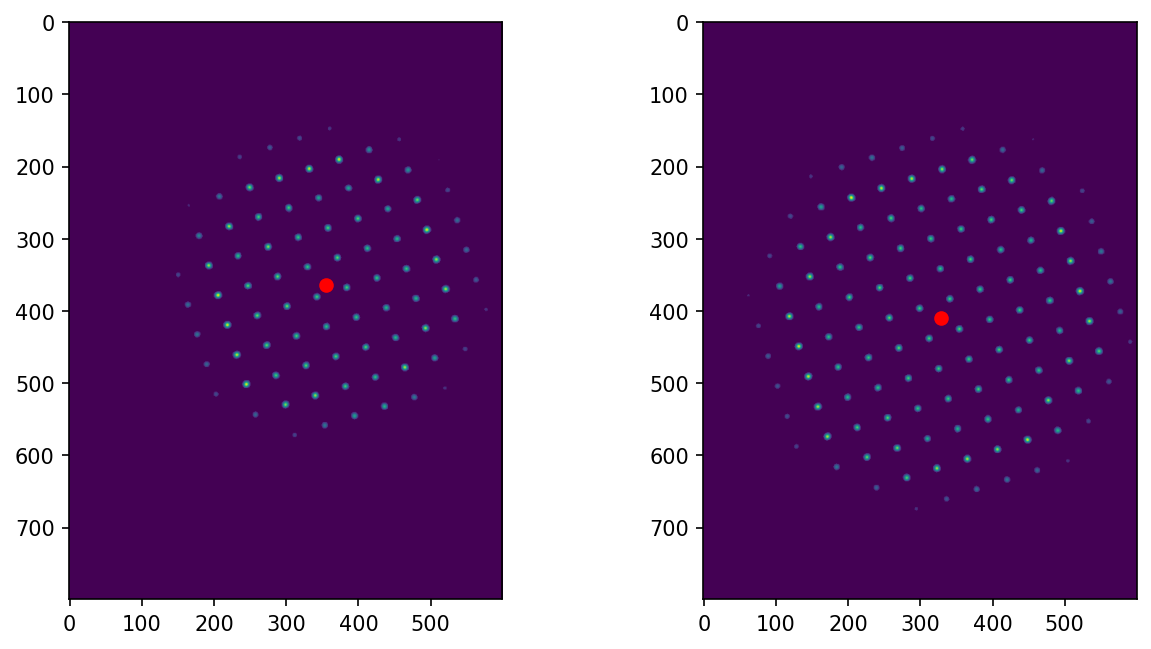

In [20]:
fig,ax = plt.subplots(1,2,figsize=(10,5),dpi=150)

ax[0].imshow(threshed_lens)
ax[0].scatter(CoM_lens[1],CoM_lens[0],c='r')
ax[1].imshow(threshed_cali)
ax[1].scatter(CoM_cali[1],CoM_cali[0],c='r')



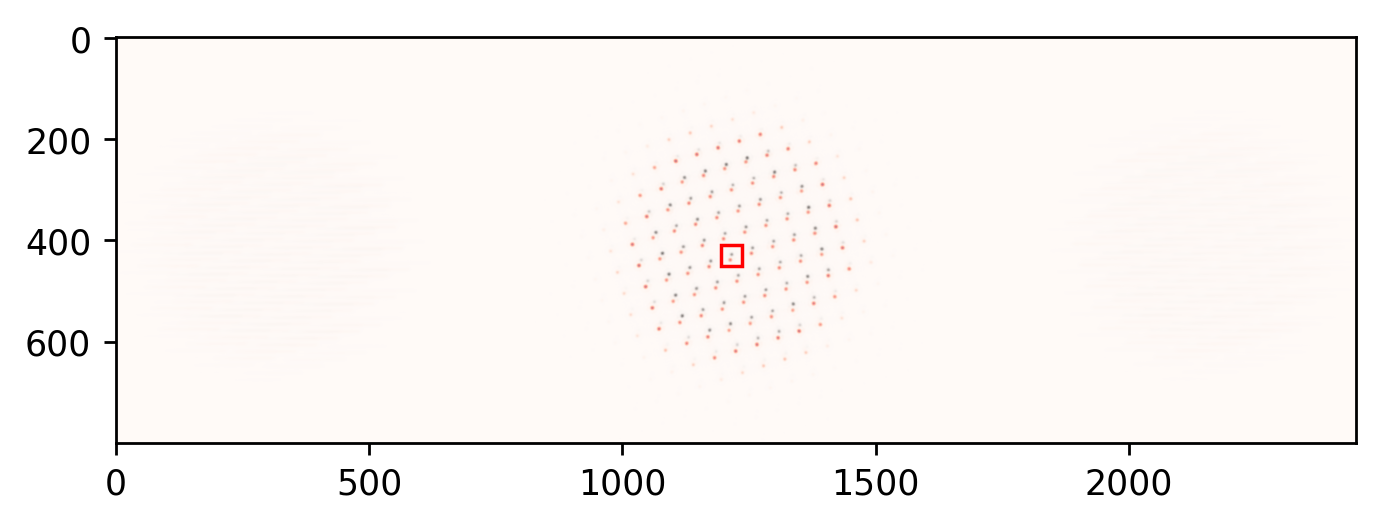

In [21]:
fig, ax = plt.subplots(dpi=250)
ax.imshow(shifted_lens_measurement,cmap='Greys')
ax.imshow(cali_measurement,alpha=0.5,cmap='Reds')

box = [1195,1235,410,450]

from matplotlib.patches import Rectangle
rect = Rectangle((box[0],box[2]),box[1]-box[0],box[3]-box[2],alpha=1,fill=False, color='r', linewidth=1)
ax.add_patch(rect)

plt.show()

In [22]:
CoM_cali = center_of_mass(cali_measurement[box[2]:box[3],box[0]:box[1]].numpy()) + np.array([box[2],box[0]])
CoM_lens = center_of_mass(shifted_lens_measurement[box[2]:box[3],box[0]:box[1]]) + np.array([box[2],box[0]])

approx_shift = np.array(CoM_cali) - np.array(CoM_lens)

shifted_lens_measurement = scipy.ndimage.shift(lens_measurement, approx_shift)

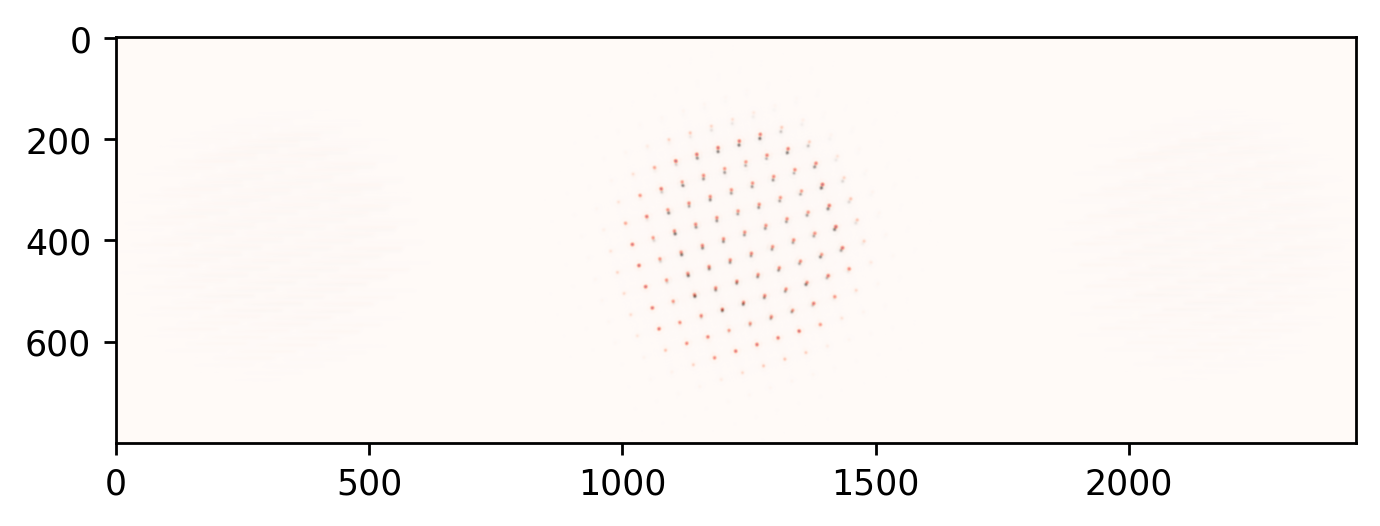

In [23]:
fig, ax = plt.subplots(dpi=250)
ax.imshow(shifted_lens_measurement,cmap='Greys')
ax.imshow(cali_measurement,alpha=0.5,cmap='Reds')

In [24]:
lens_all_m1s, lens_all_p1s, lens_all_fs, lens_center_wl_peak_positions_m1, lens_center_wl_peak_positions_p1, lens_center_wl_peak_positions_f  = extract_peaks(torch.tensor(shifted_lens_measurement))

lens_x_data_test = collate_data(lens_all_m1s, lens_all_p1s, lens_all_fs)

expected, variance = variance_model(lens_x_data_test)

expected = expected.cpu().detach().numpy()
variance = variance.cpu().detach().numpy() 

expected = np.einsum('ijk,lk->ijl',expected,correlation_matrix)
variance = np.einsum('ijk,lk->ijl',variance,correlation_matrix)

std = np.sqrt(variance)

lens_intensities = expected[:,0]

lens_peak_locations = np.zeros((len(cali_all_m1s),2,n_wl))

lens_peak_locations[:,0] = lens_center_wl_peak_positions_f[:,0][:,None] + expected[:,1]
lens_peak_locations[:,1] = lens_center_wl_peak_positions_f[:,1][:,None] + expected[:,2]

lens_std = std

In [25]:
dist = cdist(cali_center_wl_peak_positions_f, lens_center_wl_peak_positions_f)

dist[dist<20] = 0

comparible_peaks = np.where(dist==0)

Text(0.5, 1.0, 'pos y')

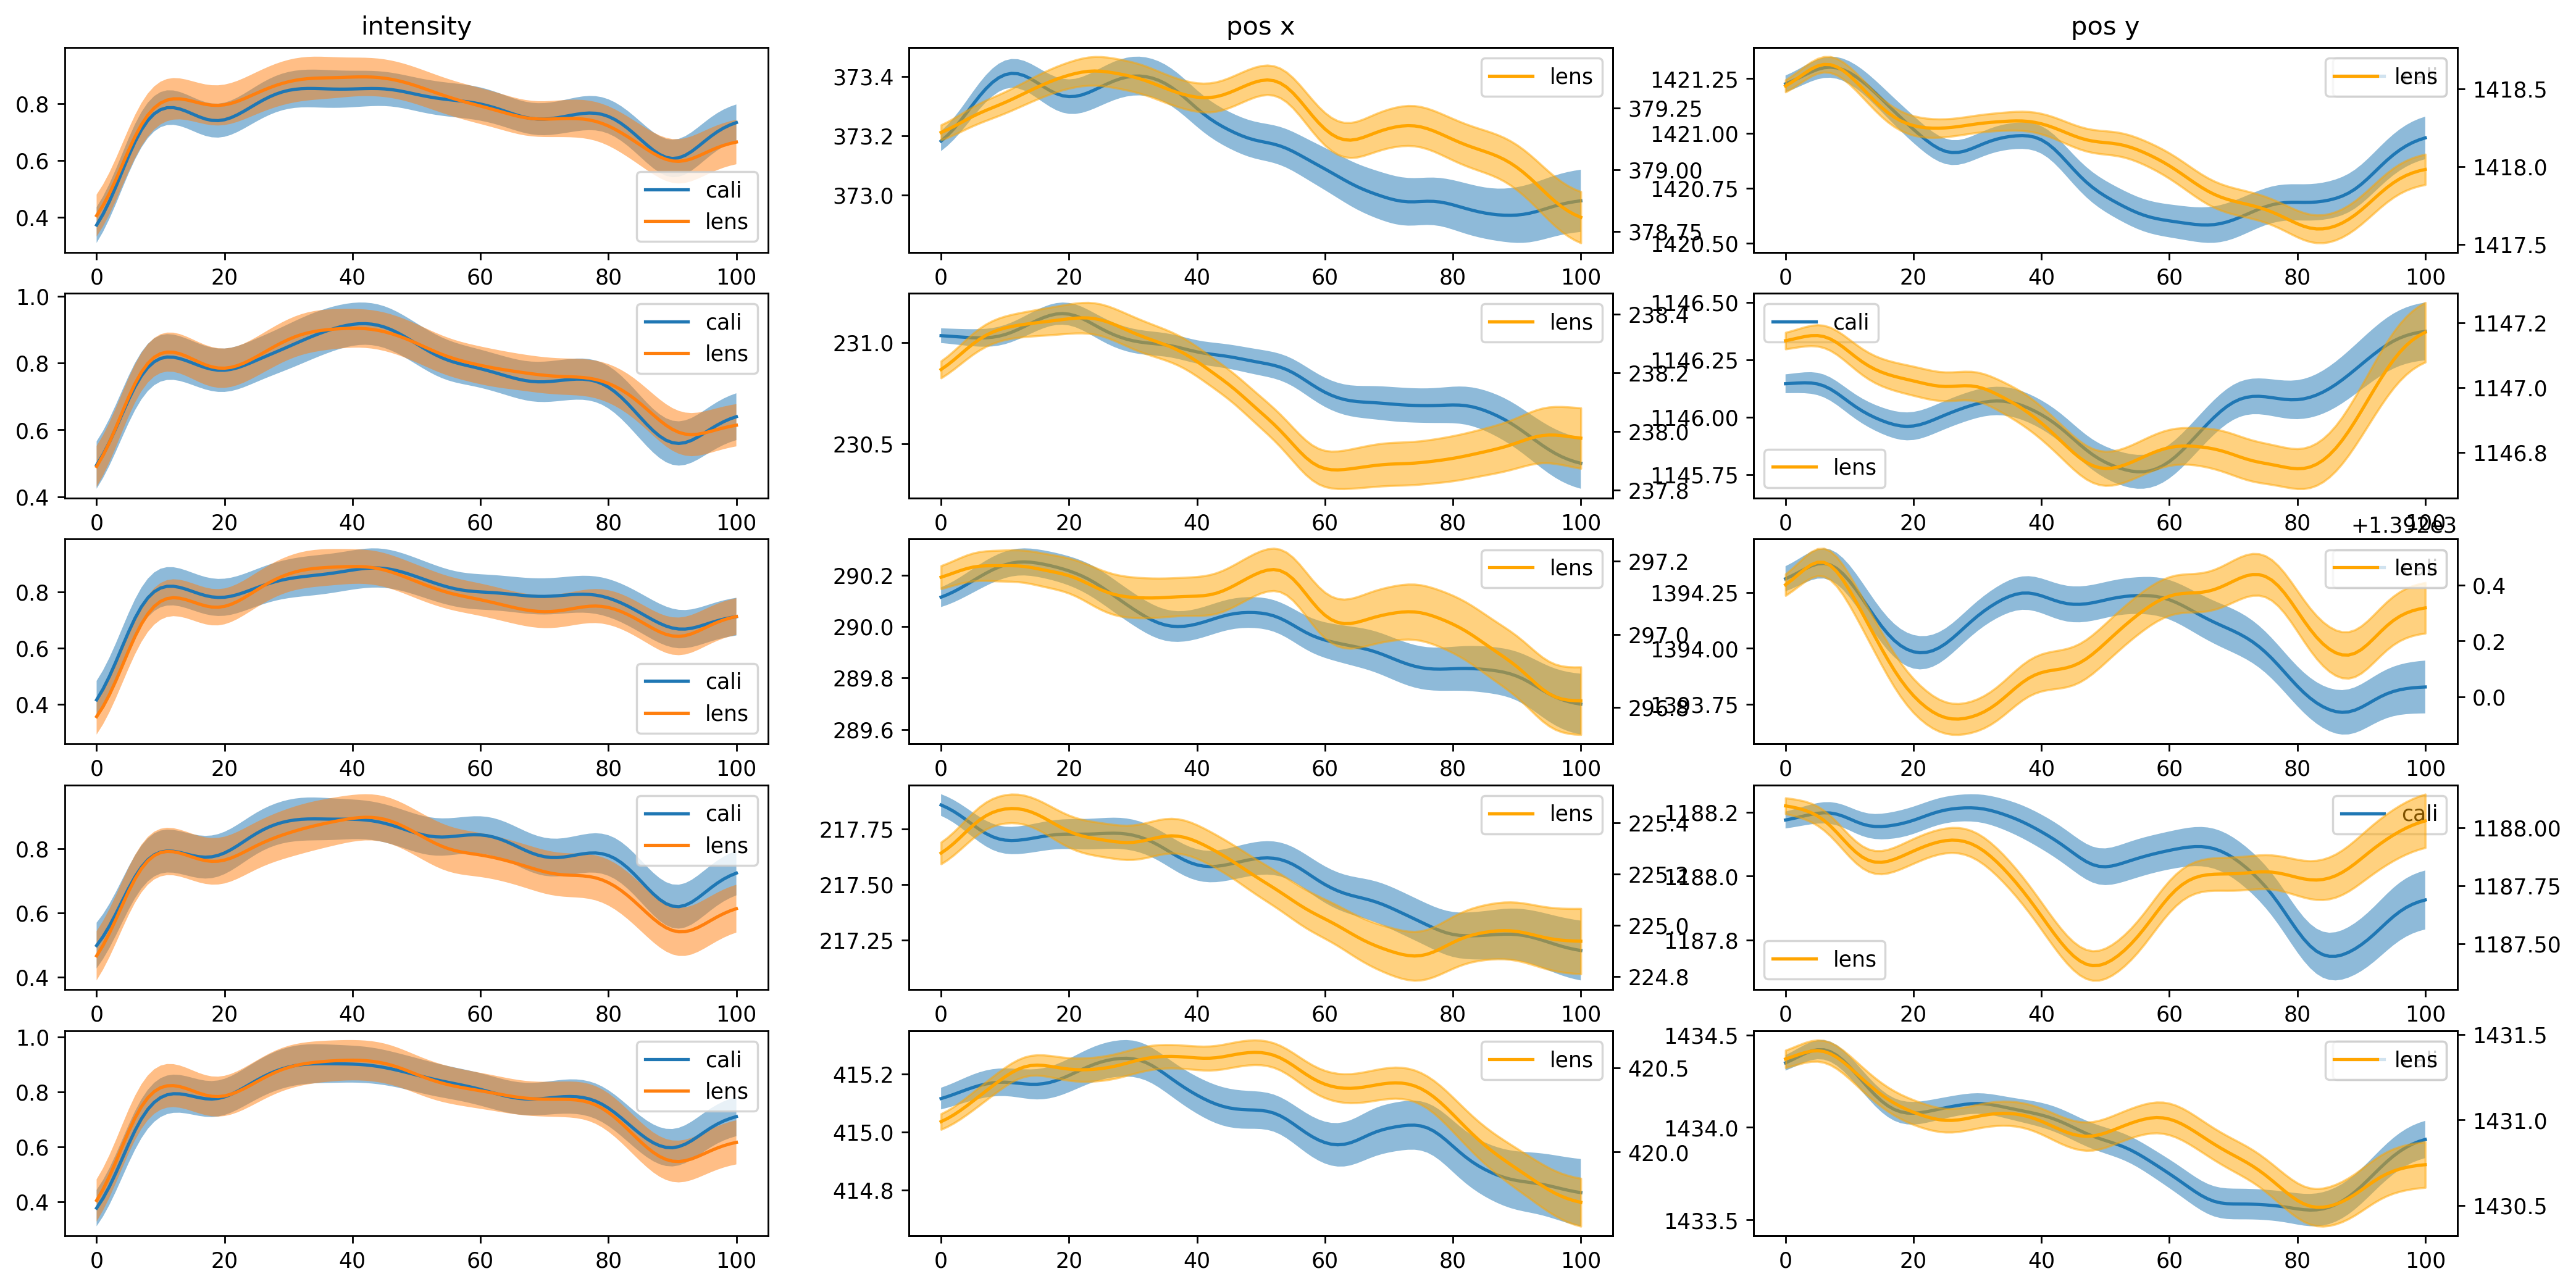

In [31]:
fig,ax = plt.subplots(5,3,figsize=(20,10),dpi=250)

no_sigma = 1

for i in range(5):
    cali_idx = comparible_peaks[0][i]
    lens_idx = comparible_peaks[1][i]
    ax[i,0].plot(cali_intensities[cali_idx], label = 'cali')
    ax[i,0].fill_between(np.arange(len(cali_intensities[cali_idx])), cali_intensities[cali_idx]-cali_std[cali_idx,0]  * no_sigma, cali_intensities[cali_idx]+cali_std[cali_idx,0] * no_sigma, alpha = 0.5)
    ax[i,0].plot(lens_intensities[lens_idx], label = 'lens')
    ax[i,0].fill_between(np.arange(len(lens_intensities[lens_idx])), lens_intensities[lens_idx]-lens_std[lens_idx,0]  * no_sigma, lens_intensities[lens_idx]+lens_std[lens_idx,0] * no_sigma, alpha = 0.5)
    ax[i,0].legend()

    ax[i,1].plot(cali_peak_locations[cali_idx,0], label = 'cali')
    ax[i,1].fill_between(np.arange(len(cali_intensities[cali_idx])), cali_peak_locations[cali_idx,0]-cali_std[cali_idx,1]  * no_sigma, cali_peak_locations[cali_idx,0]+cali_std[cali_idx,1] * no_sigma, alpha = 0.5)

    ax2 = ax[i,1].twinx()
    ax2.plot(lens_peak_locations[lens_idx,0], label = 'lens', color='orange')
    ax2.fill_between(np.arange(len(lens_intensities[lens_idx])), lens_peak_locations[lens_idx,0]-lens_std[lens_idx,1]  * no_sigma, lens_peak_locations[lens_idx,0]+lens_std[lens_idx,1] * no_sigma, alpha = 0.5, color='orange')
    ax2.legend()

    # ax[i,1].plot(lens_peak_locations[lens_idx,0], label = 'lens')
    # ax[i,1].fill_between(np.arange(len(lens_intensities[lens_idx])), lens_peak_locations[lens_idx,0]-lens_std[lens_idx,1]  * no_sigma, lens_peak_locations[lens_idx,0]+lens_std[lens_idx,1] * no_sigma, alpha = 0.5)
    # ax[i,1].legend()

    ax[i,2].plot(cali_peak_locations[cali_idx,1], label = 'cali')
    ax[i,2].fill_between(np.arange(len(cali_intensities[cali_idx])), cali_peak_locations[cali_idx,1]-cali_std[cali_idx,2]  * no_sigma, cali_peak_locations[cali_idx,1]+cali_std[cali_idx,2] * no_sigma, alpha = 0.5)

    ax2 = ax[i,2].twinx()
    ax2.plot(lens_peak_locations[lens_idx,1], label = 'lens', color='orange')
    ax2.fill_between(np.arange(len(lens_intensities[lens_idx])), lens_peak_locations[lens_idx,1]-lens_std[lens_idx,2]  * no_sigma, lens_peak_locations[lens_idx,1]+lens_std[lens_idx,2] * no_sigma, alpha = 0.5, color='orange')
    ax2.legend()


    # ax[i,2].plot(lens_peak_locations[lens_idx,1], label = 'lens')
    # ax[i,2].fill_between(np.arange(len(lens_intensities[therm_idx])), lens_peak_locations[lens_idx,1]-lens_std[lens_idx,2]  * no_sigma, lens_peak_locations[lens_idx,1]+lens_std[lens_idx,2] * no_sigma, alpha = 0.5)
    ax[i,2].legend()

ax[0,0].set_title('intensity'); ax[0,1].set_title('pos x'); ax[0,2].set_title('pos y')